# 1. Import and Install Dependencies

In [26]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix, classification_report
import tensorflow as tf

# 2. Keypoints using MP Holistic

In [27]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 

In [28]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False                  
    results = model.process(image)                 
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [29]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [30]:
def draw_styled_landmarks(image, results):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_drawing.draw_landmarks(image_rgb, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(255,102,102), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,178,102), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image_rgb, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(102,255,102), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(102,178,255), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image_rgb, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,102,178), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(178,102,255), thickness=2, circle_radius=2)
                             )  
    mp_drawing.draw_landmarks(image_rgb, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,204,102), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(102,204,255), thickness=2, circle_radius=2)
                             ) 
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    return image_bgr

In [7]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        image = draw_styled_landmarks(image, results)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
draw_styled_landmarks(frame, results)

array([[[112, 148, 169],
        [113, 149, 170],
        [115, 151, 171],
        ...,
        [123, 121, 117],
        [123, 122, 116],
        [122, 121, 114]],

       [[112, 148, 169],
        [113, 149, 170],
        [115, 151, 171],
        ...,
        [122, 121, 117],
        [122, 122, 116],
        [121, 121, 114]],

       [[112, 148, 169],
        [113, 149, 170],
        [115, 151, 171],
        ...,
        [121, 122, 116],
        [121, 122, 116],
        [120, 121, 114]],

       ...,

       [[ 13,  25,  29],
        [ 11,  23,  27],
        [  9,  21,  25],
        ...,
        [ 64,  70,  66],
        [ 65,  70,  66],
        [ 65,  70,  66]],

       [[ 11,  23,  27],
        [  9,  21,  25],
        [  7,  19,  23],
        ...,
        [ 64,  70,  65],
        [ 65,  70,  65],
        [ 65,  70,  65]],

       [[  9,  21,  25],
        [  8,  20,  24],
        [  6,  18,  23],
        ...,
        [ 64,  71,  64],
        [ 65,  70,  64],
        [ 65,  70,  64]]

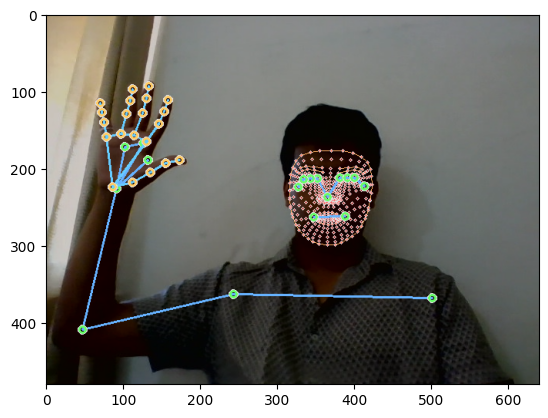

In [9]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [31]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [32]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [33]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [34]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [35]:
result_test = extract_keypoints(results)

In [36]:
np.save('0', result_test)

In [37]:
np.load('0.npy')

array([ 0.57043707,  0.49381125, -0.77389801, ...,  0.1103864 ,
        0.24040131, -0.0403621 ])

# 4. Setup Folders for Collection

In [12]:
DATA_PATH = os.path.join('MP_Data') 

actions = np.array(['hello', 'thanks', 'iloveyou'])

no_sequences = 15

sequence_length = 30

In [13]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [80]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):

                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                image = draw_styled_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                   
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                  
                    cv2.imshow('OpenCV Feed', image)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [81]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [16]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [17]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [18]:
X = np.array(sequences)

In [19]:
X.shape

(45, 30, 1662)

In [20]:
y = to_categorical(labels).astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# 7. Build and Train LSTM Neural Network

In [22]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [23]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\Leaf's Study\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
res = [.7, 0.2, 0.1]
actions[np.argmax(res)]

'hello'

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs = 110, callbacks=[tb_callback])

Epoch 1/110


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - categorical_accuracy: 0.3160 - loss: 1.0970
Epoch 2/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_accuracy: 0.3368 - loss: 1.0972
Epoch 3/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.3894 - loss: 1.0965
Epoch 4/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3998 - loss: 1.0982
Epoch 5/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.3839 - loss: 1.0987
Epoch 6/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.3631 - loss: 1.0986
Epoch 7/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.3631 - loss: 1.0976
Epoch 8/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.3839 - loss: 1.0986
Epoch 9/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3423 - loss: 1.0963
Epoch 10/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_accuracy: 0.3527 - loss: 1.0965
Epoch 11/110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

# 8. Make Predictions

In [40]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


In [41]:
actions[np.argmax(res[1])]

'hello'

In [42]:
actions[np.argmax(y_test[2])]

'thanks'

# 9. Save Weights

In [43]:
model.save('my_model.keras')

In [44]:
model.load_weights('my_model.keras')

# 10. Evaluation using Confusion Matrix and Accuracy

In [45]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [46]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [47]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[0, 2],
        [0, 1]],

       [[1, 0],
        [2, 0]]], dtype=int64)

In [48]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [104]:
def plot_accuracy(history):
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    if 'val_categorical_accuracy' in history.history:
        plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [105]:
def plot_confusion_matrix(y_true, y_hat, classes):
    cm = confusion_matrix(y_true, y_hat)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [106]:
def print_classification_report(y_true, y_hat, classes):
    unique_classes = np.unique(np.concatenate([y_true, y_hat]))
    print(classification_report(y_true, y_hat, labels=unique_classes, target_names=classes))

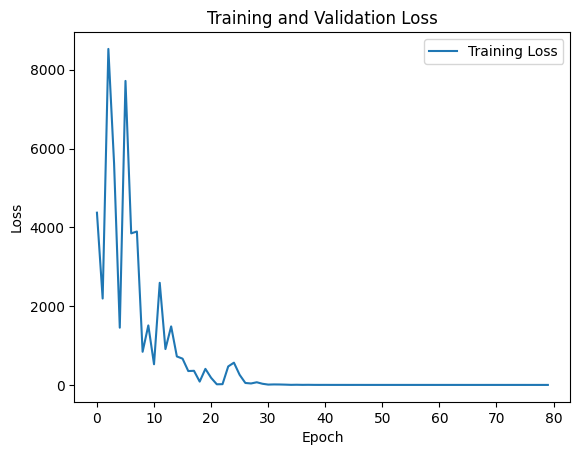

In [107]:
plot_loss(history)

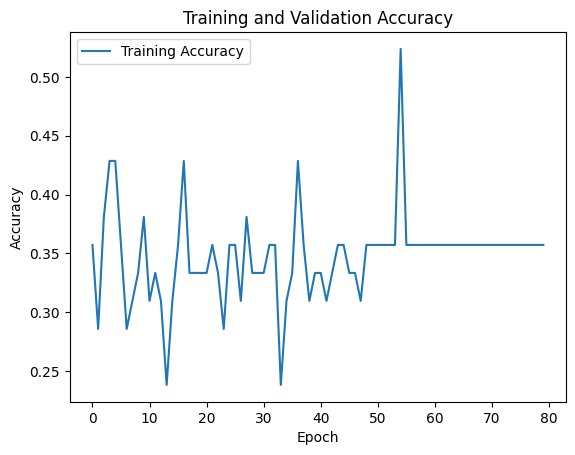

In [108]:
plot_accuracy(history)

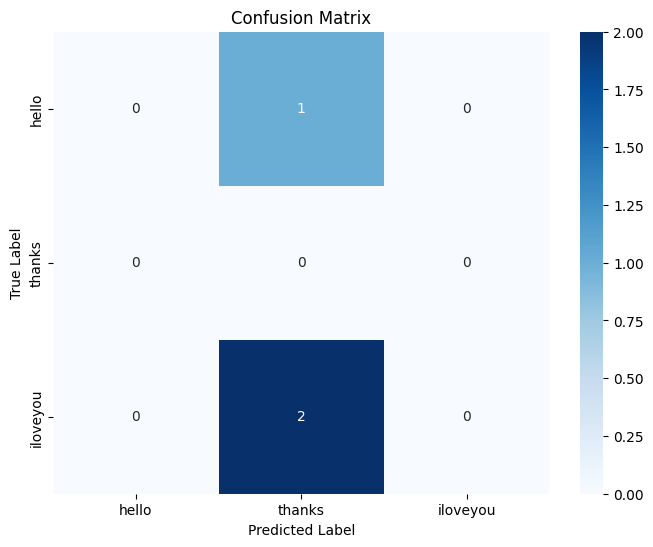

In [109]:
plot_confusion_matrix(ytrue, yhat ,actions)

In [110]:
print_classification_report(ytrue, yhat, actions)

              precision    recall  f1-score   support

       hello       0.00      0.00      0.00       1.0
      thanks       0.00      0.00      0.00       0.0
    iloveyou       0.00      0.00      0.00       2.0

    accuracy                           0.00       3.0
   macro avg       0.00      0.00      0.00       3.0
weighted avg       0.00      0.00      0.00       3.0



c:\Users\Leaf's Study\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Leaf's Study\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Leaf's Study\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn

In [111]:
training_loss = history.history['loss']
learning_rate_per_epoch = [optimizer.learning_rate.numpy() for _ in range(len(history.epoch))]
epochs = range(1, len(training_loss) + 1)  
learning_rates = range(1, len(learning_rate_per_epoch) + 1)

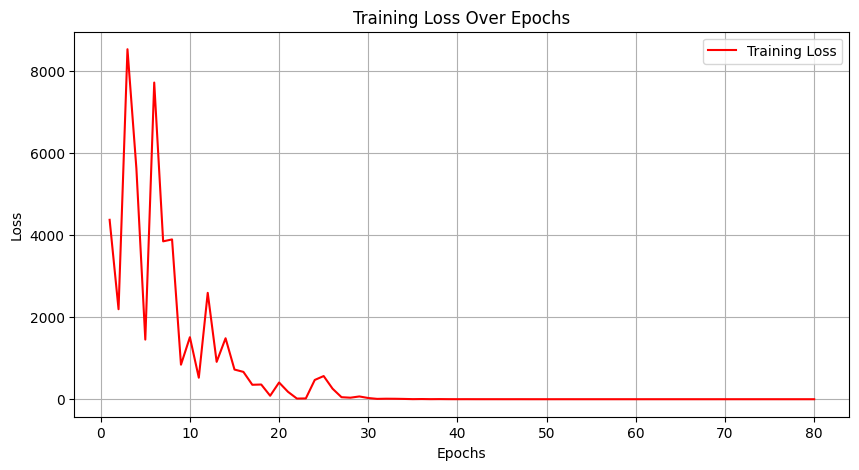

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'r', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

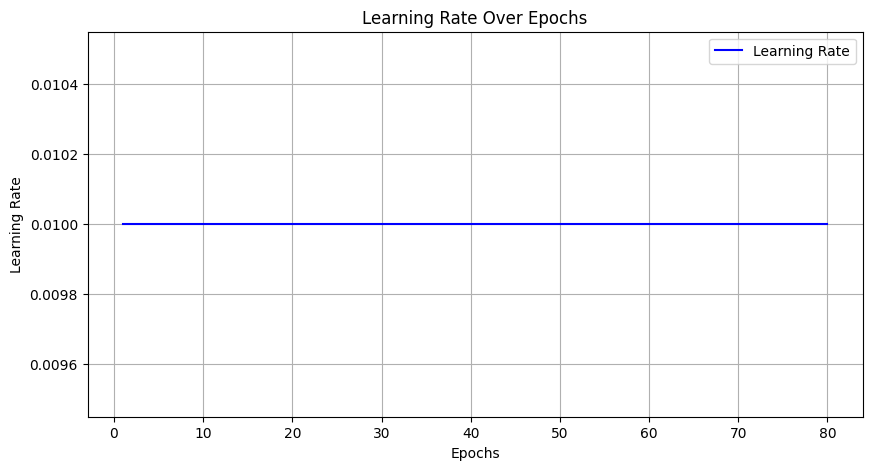

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, learning_rate_per_epoch, 'b', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

In [114]:
accuracy = accuracy_score(ytrue, yhat)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.0


# 11. Test in Real Time

In [115]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [116]:

sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        image = draw_styled_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-15:]
        
        if len(sequence) == 15:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
hello